In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

In [2]:
import pandas as pd

import causalpy as cp

# ITS - refactored code

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


## Bayesian

In [4]:
pymc_result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [5]:
pymc_result.print_coefficients()

Model coefficients:
    Intercept       23, 94% HDI [21, 24]
    C(month)[T.2]   2.9, 94% HDI [0.88, 4.8]
    C(month)[T.3]   1.2, 94% HDI [-0.81, 3.1]
    C(month)[T.4]   7.1, 94% HDI [5.2, 9.1]
    C(month)[T.5]   15, 94% HDI [13, 17]
    C(month)[T.6]   25, 94% HDI [23, 27]
    C(month)[T.7]   18, 94% HDI [16, 20]
    C(month)[T.8]   33, 94% HDI [32, 35]
    C(month)[T.9]   16, 94% HDI [14, 18]
    C(month)[T.10]  9.2, 94% HDI [7.2, 11]
    C(month)[T.11]  6.3, 94% HDI [4.2, 8.2]
    C(month)[T.12]  0.59, 94% HDI [-1.4, 2.5]
    t               0.21, 94% HDI [0.19, 0.23]
    sigma           2, 94% HDI [1.7, 2.3]


BayesianPlotComponent - plot_pre_post


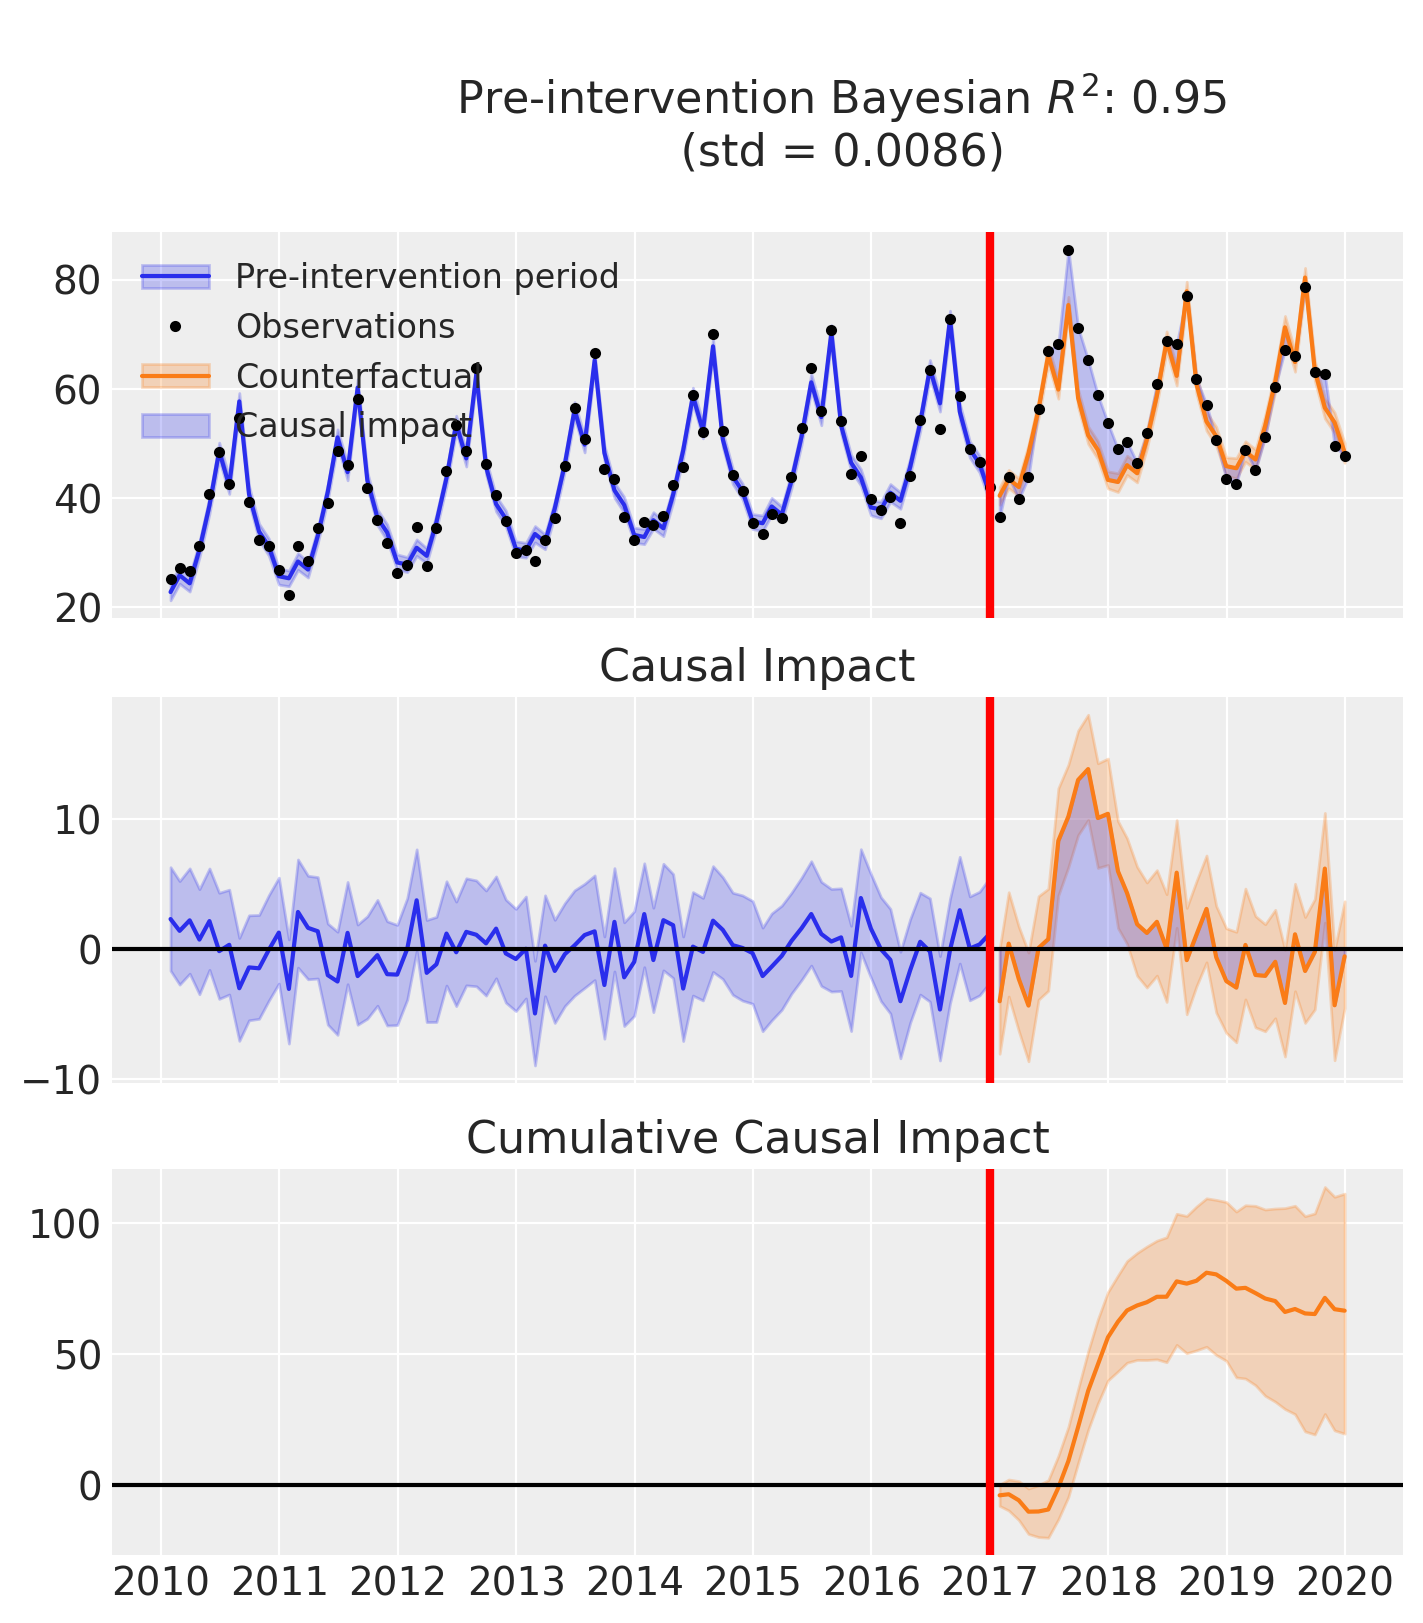

In [6]:
pymc_result.plot()

## OLS

In [7]:
ols_result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.skl_models.OLSLinearRegression(),
)

In [8]:
ols_result.print_coefficients()

Model coefficients:
  Intercept     	         0
  C(month)[T.2] 	       2.9
  C(month)[T.3] 	       1.2
  C(month)[T.4] 	       7.1
  C(month)[T.5] 	        15
  C(month)[T.6] 	        25
  C(month)[T.7] 	        18
  C(month)[T.8] 	        33
  C(month)[T.9] 	        16
  C(month)[T.10]	       9.2
  C(month)[T.11]	       6.3
  C(month)[T.12]	      0.58
  t             	      0.21


OLSPlotComponent - plot_pre_post


ValueError: x and y must have same first dimension, but have shapes (36,) and (1296,)

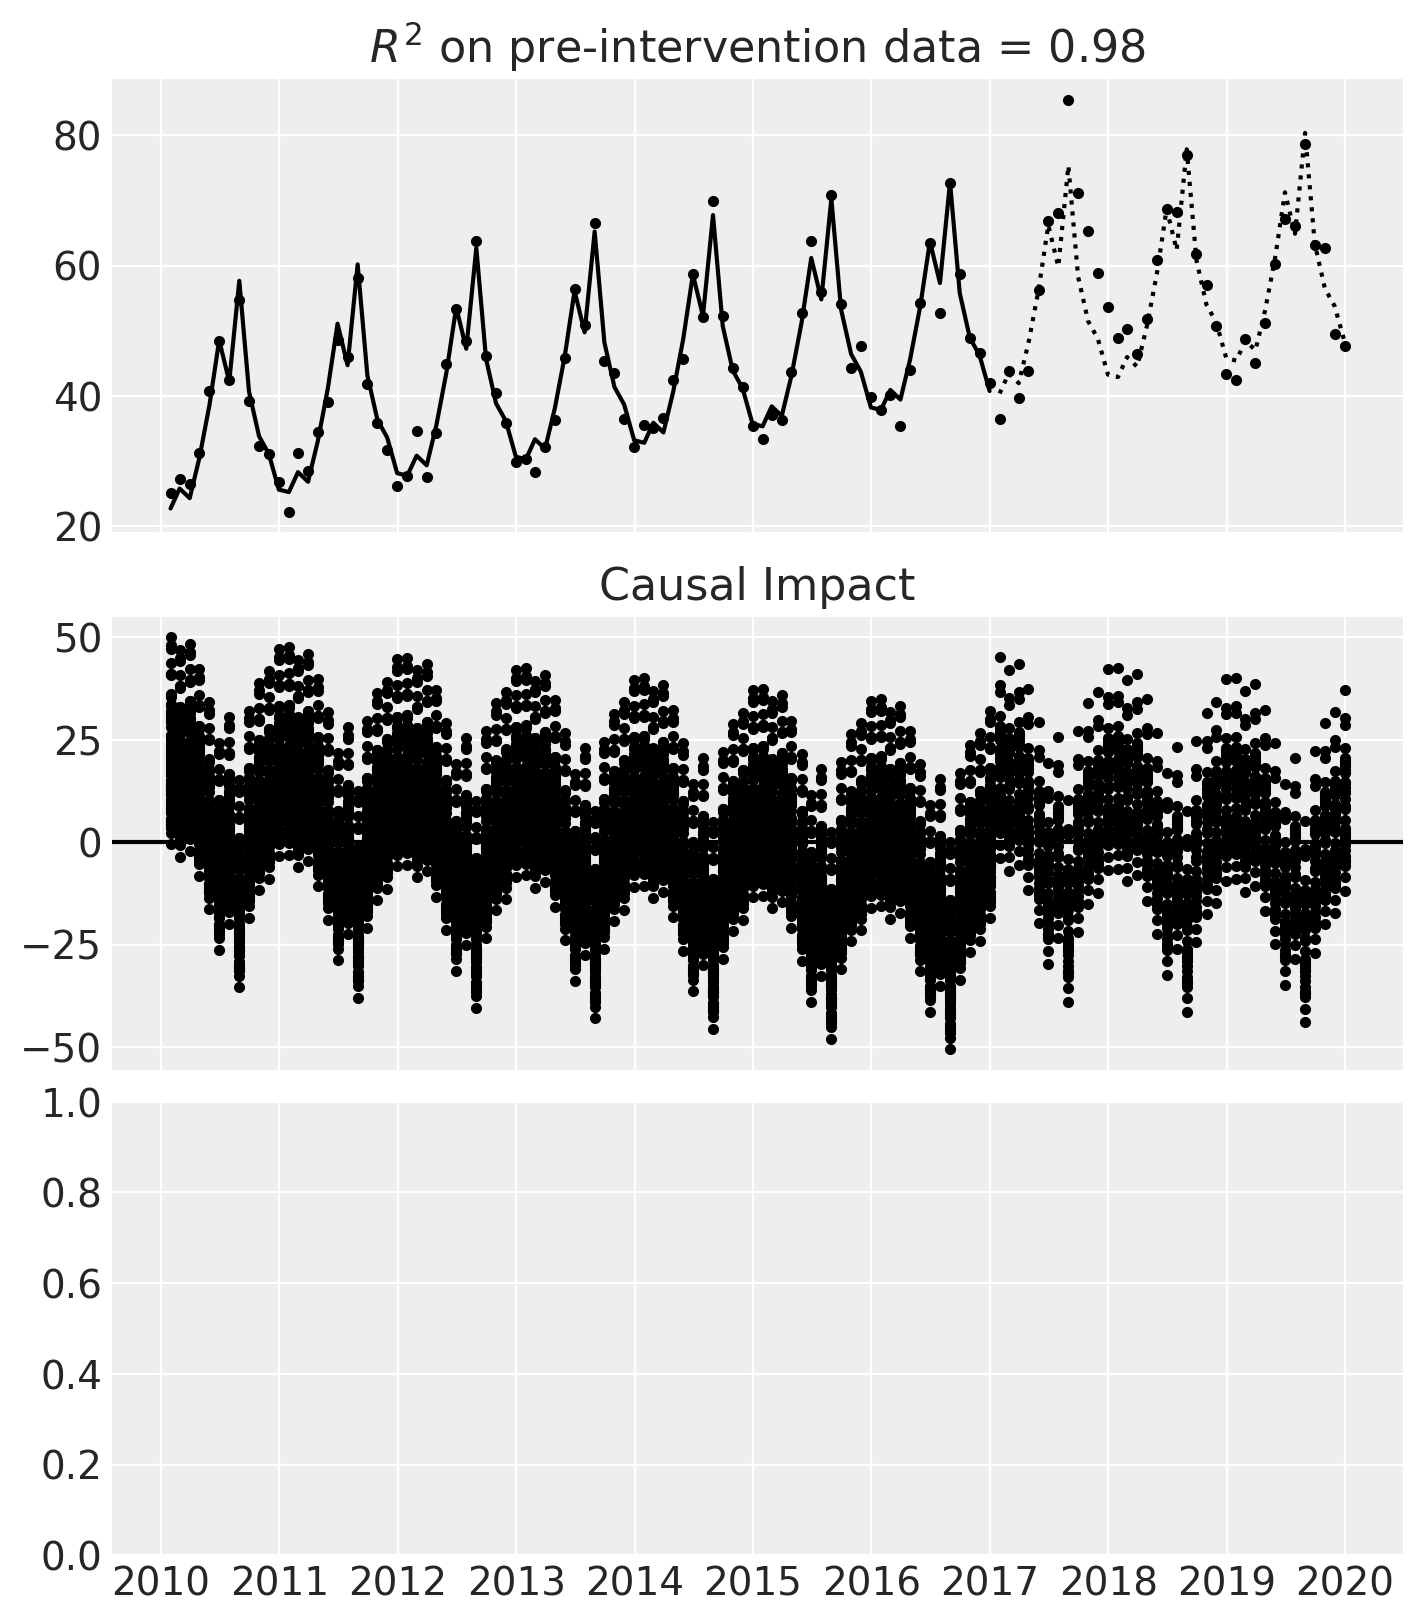

In [9]:
ols_result.plot()

# SC - refactored code

In [10]:
df = cp.load_data("sc")
treatment_time = 70

In [11]:
pymc_result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [12]:
pymc_result.print_coefficients()

Model coefficients:
    a      0.34, 94% HDI [0.3, 0.38]
    b      0.049, 94% HDI [0.01, 0.089]
    c      0.3, 94% HDI [0.26, 0.35]
    d      0.054, 94% HDI [0.01, 0.099]
    e      0.024, 94% HDI [0.0012, 0.066]
    f      0.19, 94% HDI [0.11, 0.26]
    g      0.039, 94% HDI [0.0029, 0.088]
    sigma  0.26, 94% HDI [0.22, 0.31]


BayesianPlotComponent - plot_pre_post


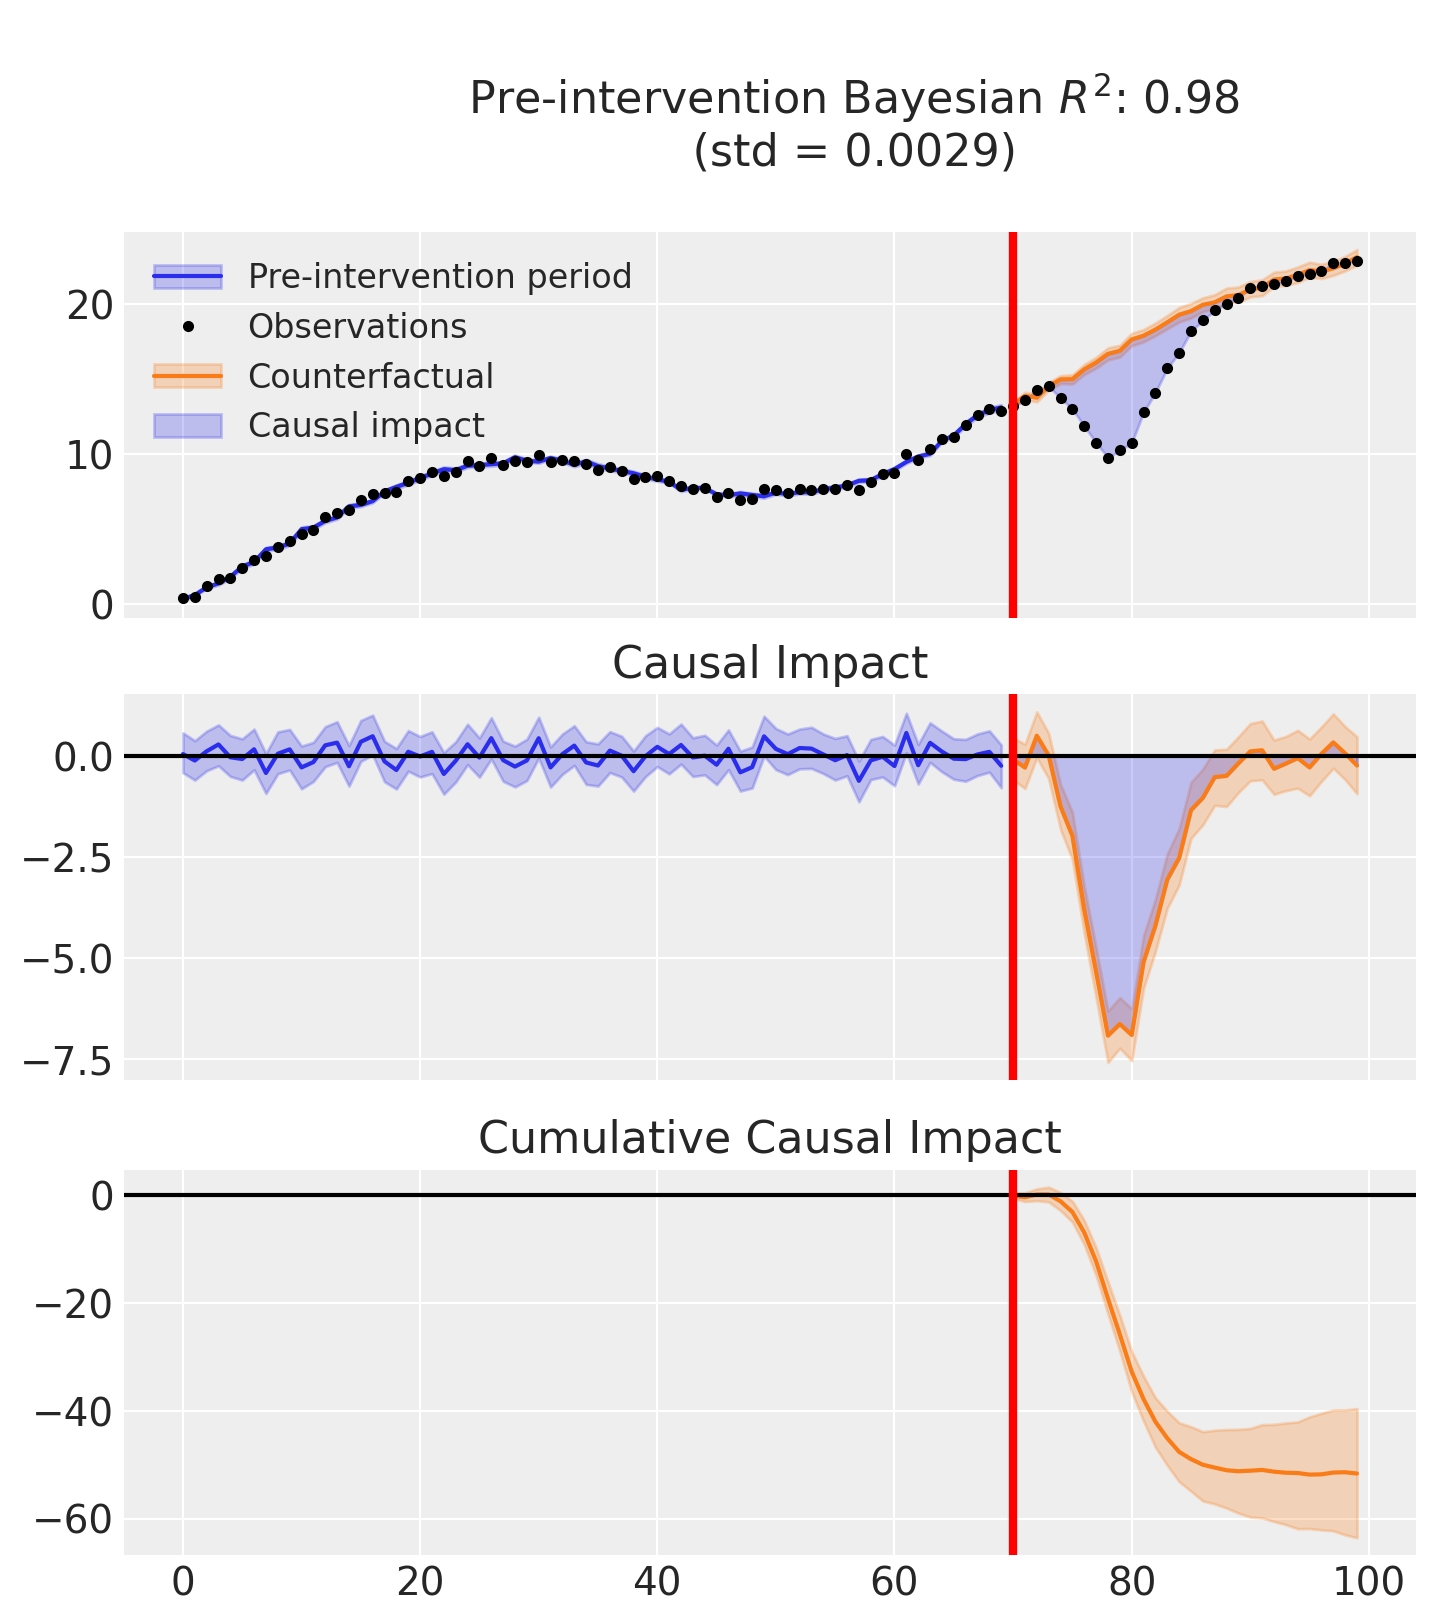

In [13]:
pymc_result.plot()

## OLS

In [14]:
# Note, we do not want an intercept in this model
ols_result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.skl_models.WeightedProportion(),
)

In [15]:
ols_result.print_coefficients()

Model coefficients:
  a	      0.38
  b	      0.17
  c	      0.44
  d	         0
  e	   5.4e-18
  f	         0
  g	         0


OLSPlotComponent - plot_pre_post


ValueError: x and y must have same first dimension, but have shapes (30,) and (900,)

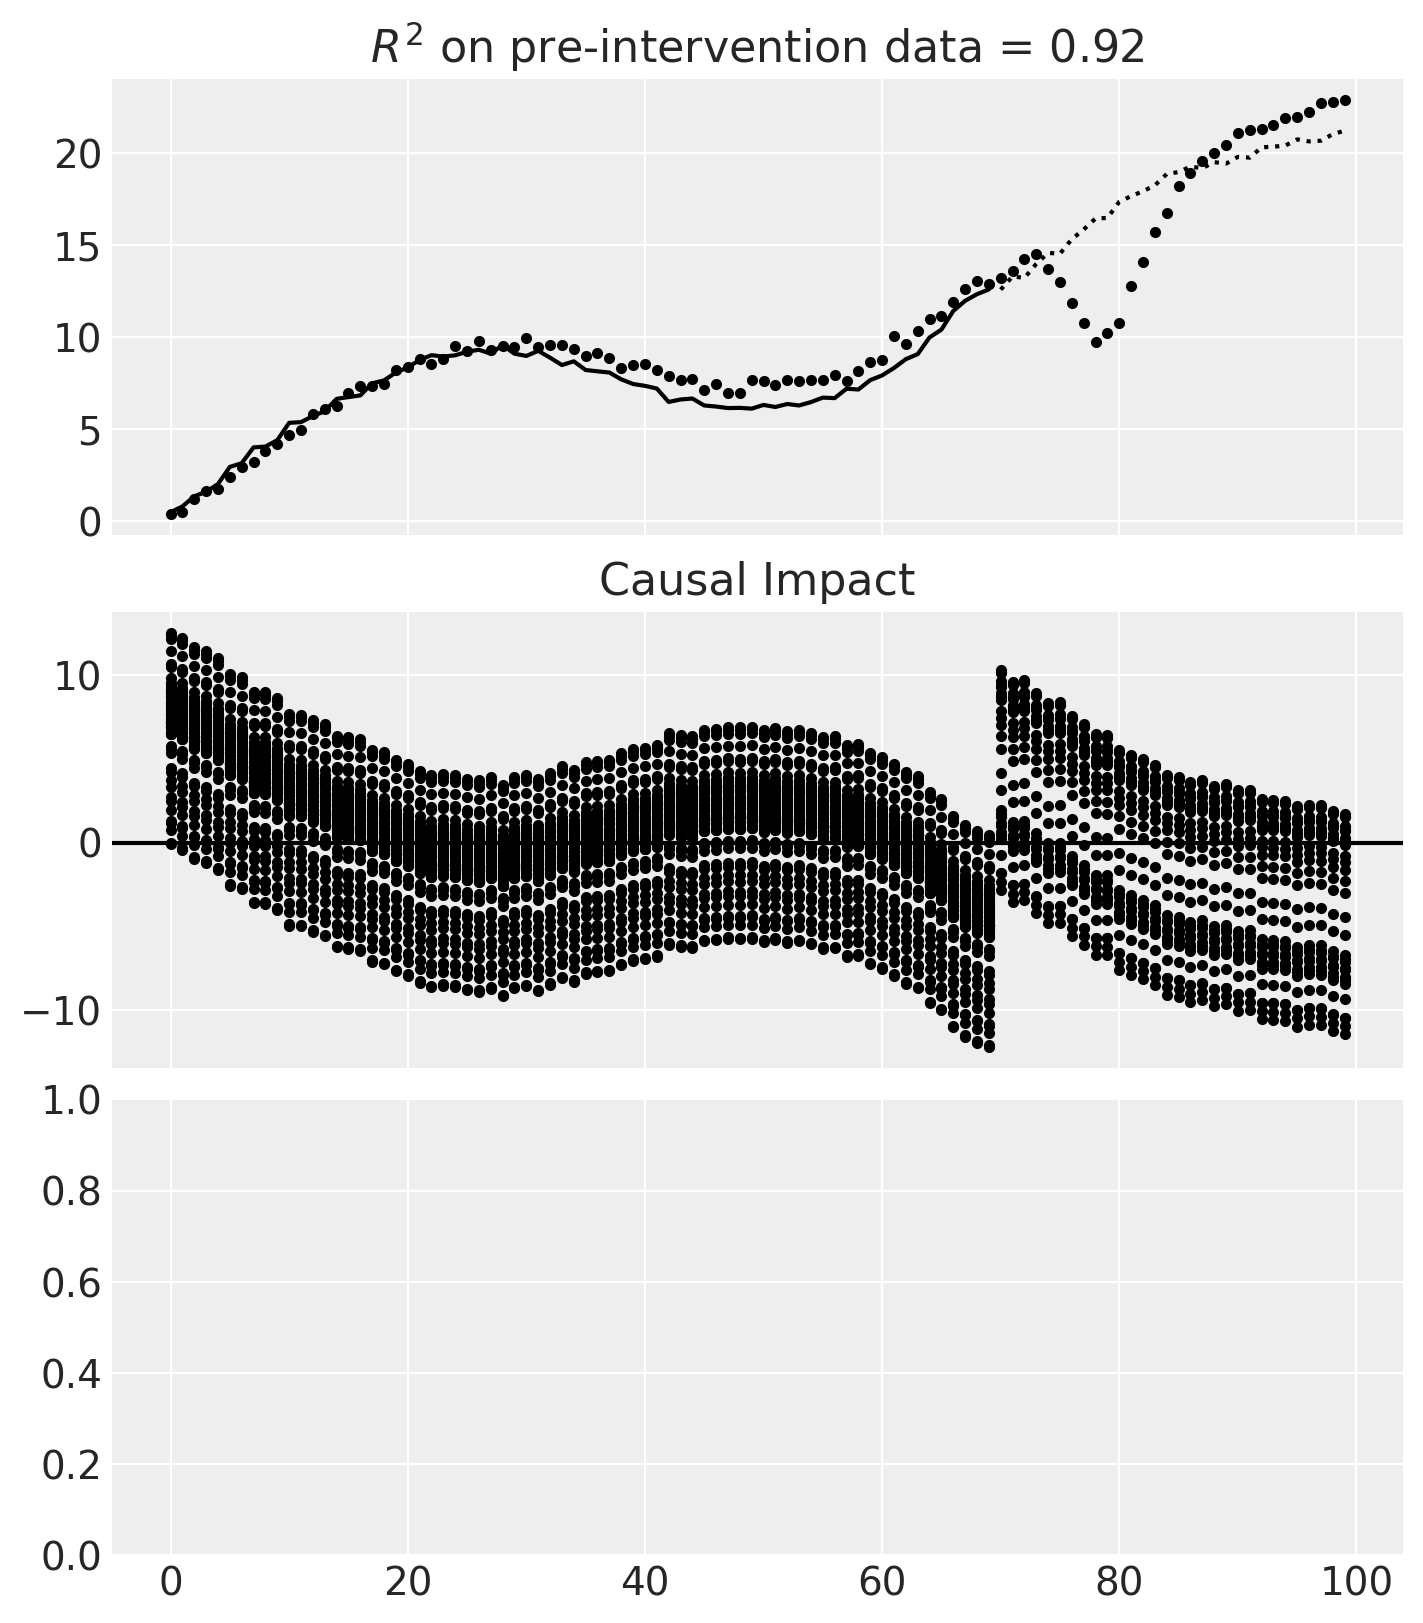

In [16]:
ols_result.plot()

# DiD - refactored code

In [17]:
df = cp.load_data("did")

In [18]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [19]:
result.print_coefficients()

Model coefficients:
    Intercept                     1.1, 94% HDI [1, 1.1]
    post_treatment[T.True]        0.99, 94% HDI [0.92, 1.1]
    group                         0.16, 94% HDI [0.094, 0.23]
    group:post_treatment[T.True]  0.5, 94% HDI [0.4, 0.6]
    sigma                         0.082, 94% HDI [0.066, 0.1]


NameError: name '_causal_impact_summary_stat' is not defined

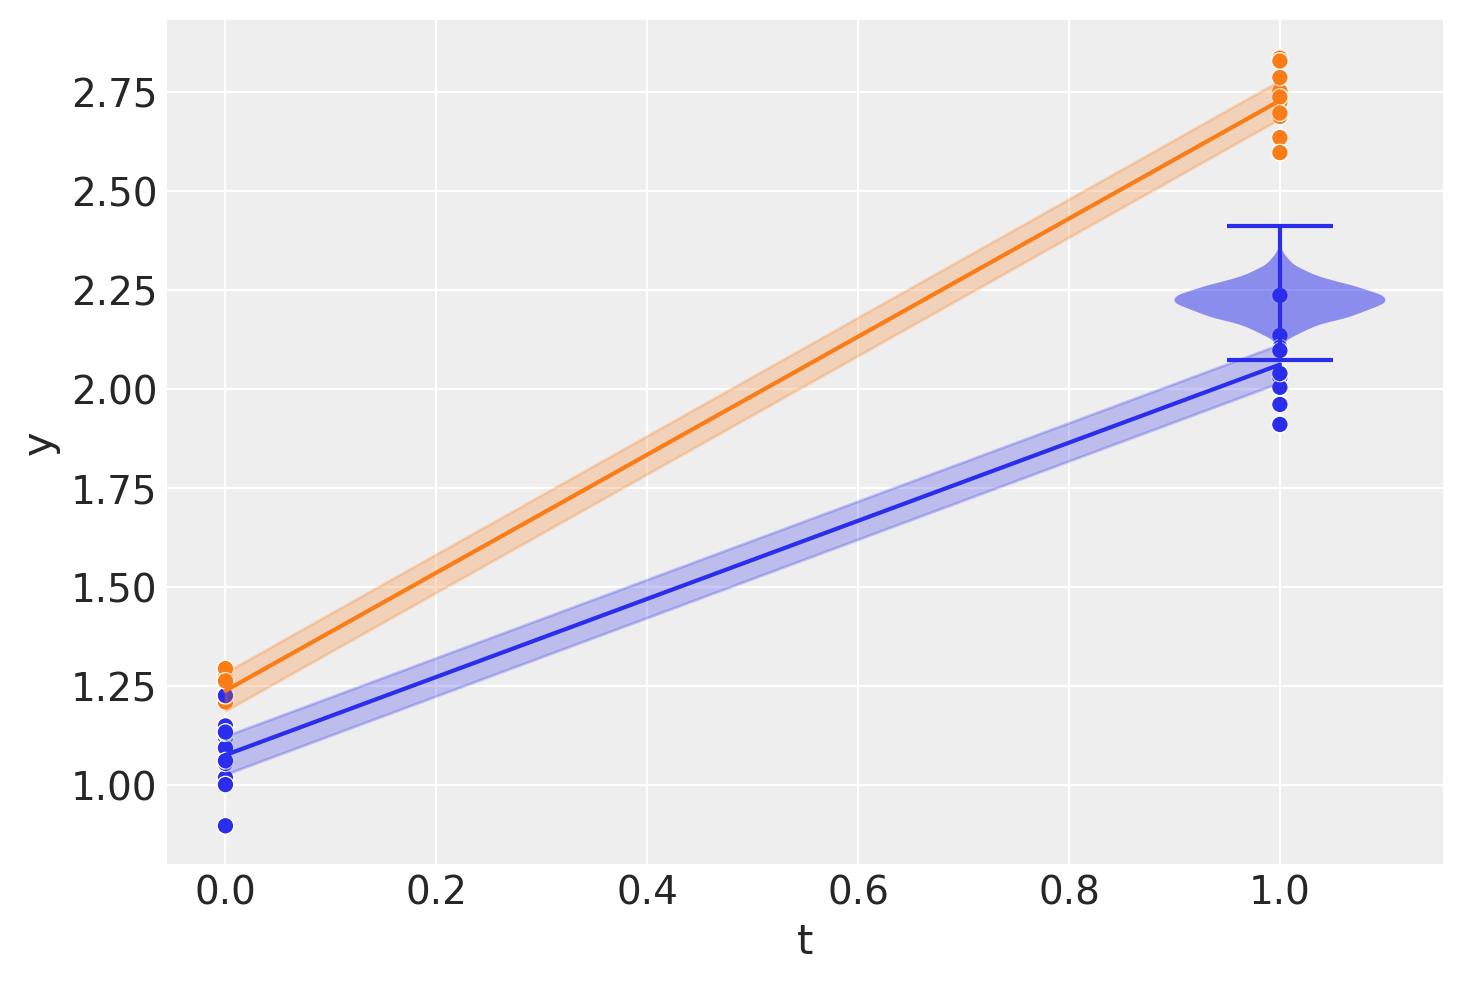

In [20]:
result.plot()

In [21]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    treated=1,
    untreated=0,
    model=cp.skl_models.OLSLinearRegression(),
)

In [22]:
result.print_coefficients()

Model coefficients:
  Intercept                   	         0
  post_treatment[T.True]      	      0.99
  group                       	      0.16
  group:post_treatment[T.True]	       0.5


NameError: name 'causal_impact' is not defined

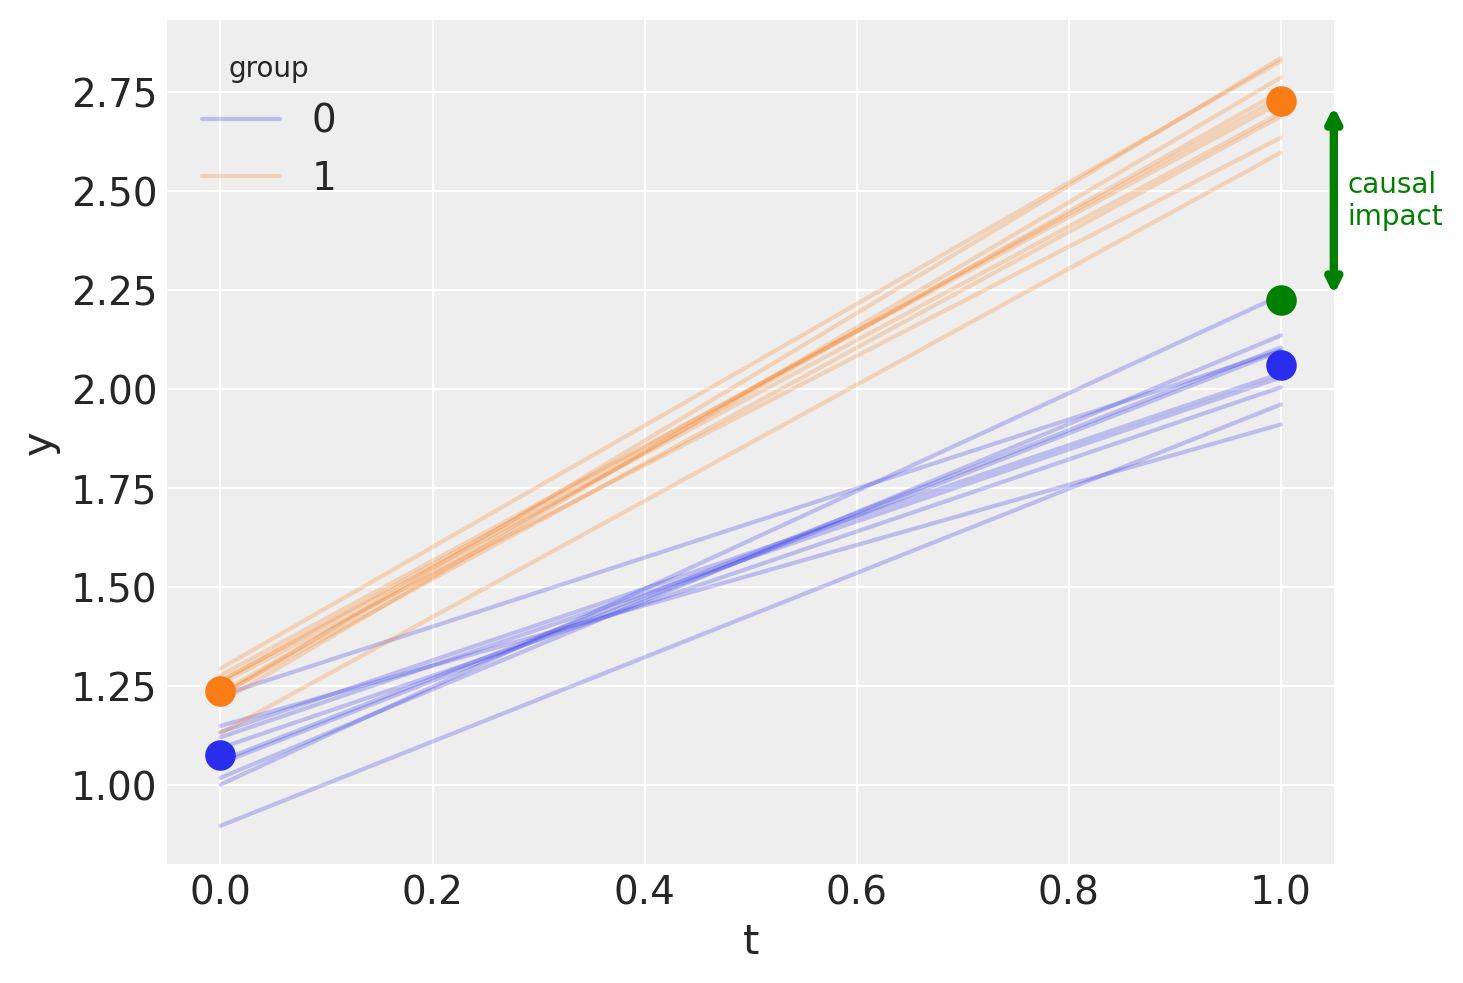

In [23]:
result.plot()

## ANOVA - Pre/Post NEGD

In [24]:
df = cp.load_data("anova1")

In [25]:
result = cp.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    pretreatment_variable_name="pre",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [26]:
result.print_coefficients()

Model coefficients:
    Intercept      -0.48, 94% HDI [-1.2, 0.23]
    C(group)[T.1]  1.9, 94% HDI [1.7, 2.1]
    pre            1, 94% HDI [0.98, 1.1]
    sigma          0.51, 94% HDI [0.46, 0.56]


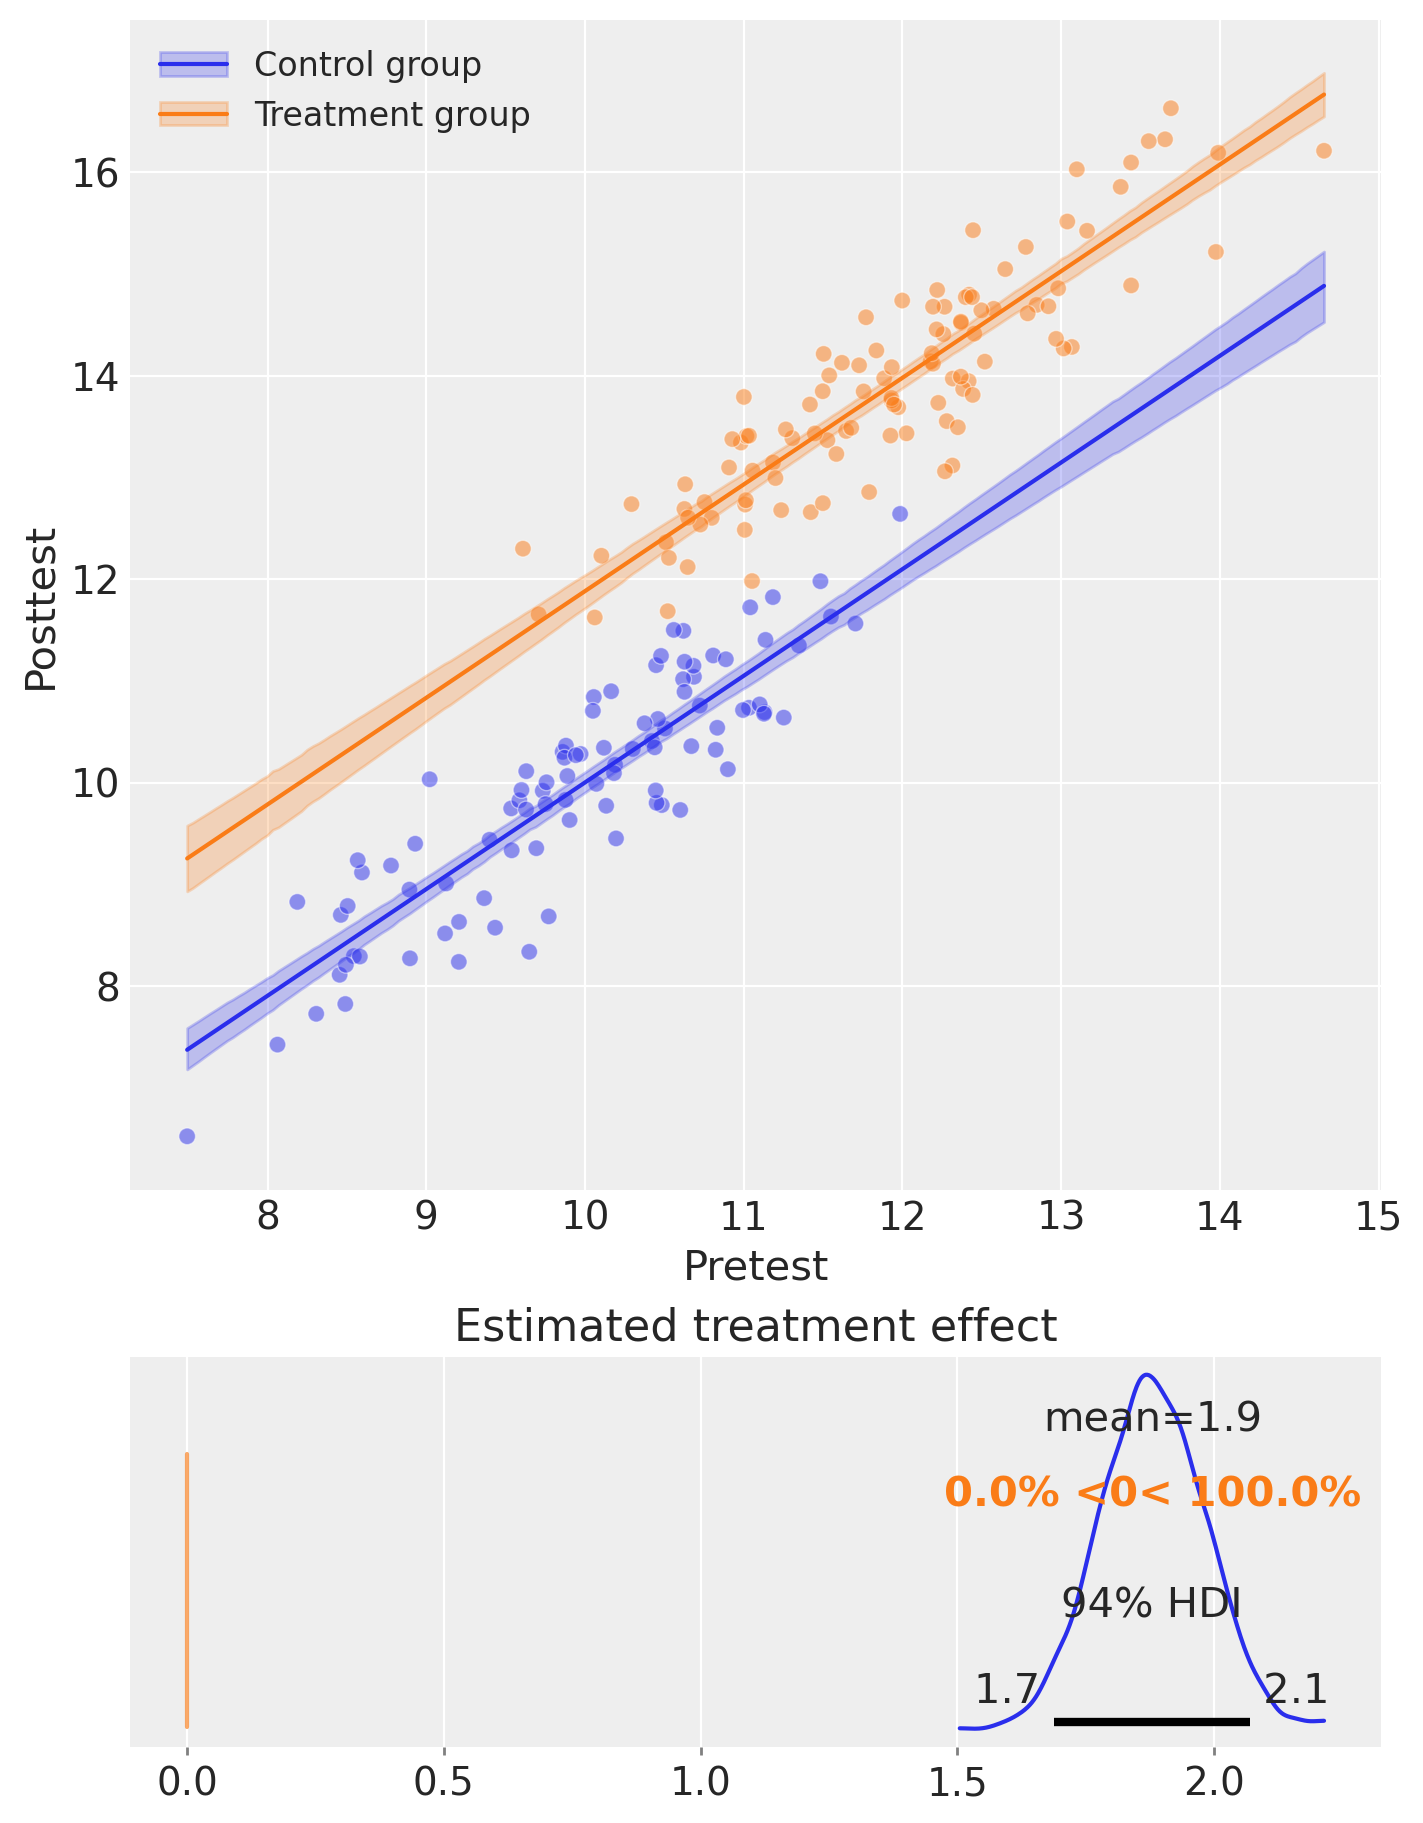

In [27]:
result.plot()